# Point Charge Dynamics
## Akiva Lipshitz, February 2, 2017

Particles and their dynamics are incredibly fascinating, even wondrous. Give me some particles and some simple equations describing their interactions – some very interesting things can start happening. 

Currently studying electrostatics in my physics class, I am interested in not only the static force and field distributions but also in the dynamics of particles in such fields. To study the dynamics of electric particles is not an easy endeavor – in fact the differential equations governing their dynamics are quite complex and not easily solved manually, especially by someone who lacks a background in differential equations. 

Instead of relying on our analytical abilities, we may rely on our computational abilities and numerically solve the differential equations. Herein I will develop a scheme for computing the dynamics of $n$ electric particles en masse. It will not be computationally easy – the number of operations grows proportionally to $n^2$. For less than $10^4$ you should be able to simulate the particle dynamics for long enough time intervals to be useful. But for something like $10^6$ particles the problem is intractable. You'll need to do more than $10^12$ operations per iteration and a degree in numerical analysis. 



## Governing Equations 

Given $n$ charges $q_1, q_2, ..., q_n$, with masses $m_1, m_2, ..., m_n$ located at positions $\vec{r}_1, \vec{r_2}, ..., \vec{r}_n$, the force induced on $q_i$ by $q_j$ is given by 

$$\vec{F}_{j \to i} = k\frac{q_iq_j}{\left|\vec{r}_i-\vec{r}_j\right|^2}\hat{r}_{ij}$$

where 

$$\hat{r}_{ij} = \vec{r}_i-\vec{r}_j$$

Now, the net *marginal* force on particle $q_i$ is given as the sum of the pairwise forces

$$\vec{F}_{N, i} = \sum_{j \ne i}{\vec{F}_{j \to i}}$$

And then the net acceleration of particle $q_i$ just normalizes the force by the mass of the particle:

$$\vec{a}_i = \frac{\vec{F}_{N, i}}{m_i}$$

To implement this at scale, we're going to need to figure out a scheme for vectorizing all these operations, demonstrated below. 

We'll be using `scipy.integrate.odeint` for our numerical integration. Below, the function `g(y, t, q, m, n, d, k)` is a function that returns the derivatives for all our variables at each iteration. We pass it to `odeint` and then do the integration. 

In [448]:
import numpy as np
import numpy.ma as ma
from scipy.integrate import odeint
mag = lambda r: np.sqrt(np.sum(np.power(r, 2)))

def g(y, t, q, m, n,d, k):
    """
    n: the number of particles
    d: the number of dimensions 
      (for fun's sake I want this 
      to work for k-dimensional systems)
    y: an (n*2,d) dimensional matrix 
        where y[:n]_i is the position
        of the ith particle and
        y[n:]_i is the velocity of 
        the ith particle
    qs: the particle charges
    ms: the particle masses
    k: the electric constant
    t: the current timestamp
    """
#     r1, r2, dr1dt, dr2dt = np.copy(y.reshape((n*2,d)))
#     F = -1./mag(r2-r1)**2

#     dy = [
#      dr1dt,
#      dr2dt,
#      (F)*(r1-r2),
#      (F)*(r2-r1),
#     ]
    y = np.copy(y.reshape((n*2,d)))

    # rj across, ri down
    rs_from = np.tile(y[:n], (n,1,1))

    # ri across, rj down
    rs_to = np.transpose(rs_from, axes=(1,0,2))

    # directional distance between each r_i and r_j
    # dr_ij is the force from j onto i, i.e. r_i - r_j
    dr = rs_to - rs_from

    # Used as a mask
    nd_identity = np.eye(n).reshape((n,n,1))

    # Force magnitudes
    drmag = ma.array(
        np.sqrt(
            np.sum(
                np.power(dr, 2), 2)), 
        mask=nd_identity)

    # Pairwise q_i*q_j for force equation
    qsa = np.tile(q, (n,1))
    qsb = np.tile(q, (n,1)).T
    qs = qsa*qsb

    
    # Directional forces
    Fs = (-qs/np.power(drmag,2)).reshape((n,n,1))

    # Dividing by m to obtain acceleration vectors
    a = np.sum(Fs*dr, 1)

    # Sliding integrated acceleration
    # (i.e. velocity from previous iteration)
    # to the position derivative slot
    y[:n] = np.copy(y[n:])

    # Entering the acceleration into the velocity slot
    y[n:] = np.copy(a)
    # Flattening it out for scipy.odeint to work
    return np.array(y).reshape(n*2*d)  



Let's define our time intervals, so that odeint knows which time stamps to iterate over. 

In [449]:
t_f = 10000
t = np.linspace(0, 10, num=t_f)

Some other constants

In [450]:
# Number of dimensions
d = 2
# Number of point charges
n = 3
# charge magnitudes, currently all equal to 1
q = np.array([-10,0.2,-5])
# masses
m = np.ones(n)

# The electric constant 
#    k=1/(4*pi*epsilon_naught)
#    Right now we will set it to 1
#    because for our tests we are choosing all q_i =1. 
#    Therefore, k*q is too large a number and causes 
#    roundoff errors in the integrator. 
# In truth:
#    k = 8.99*10**9
# But for now:
k=1.

We get to choose the initial positions and velocities of our particles. For our initial tests, we'll set up 3 particles to collide with eachother. 

In [451]:

r1i = np.array([-2., 0.0])
dr1dti = np.array([3.,0.])

r2i = np.array([20.,0.5])
dr2dti = np.array([-3., 0.])

r3i = np.array([11.,20])
dr3dti = np.array([0, -3.])

And pack them into an initial state variable we can pass to odeint. 

In [452]:
y0 = np.array([r1i, r2i, r3i, dr1dti, dr2dti, dr3dti]).reshape(n*2*d)

## The Fun Part – Doing the Integration

Now, we'll actually do the integration

In [453]:
# Doing the integration
yf = odeint(g, y0, t, args=(q,m,n,d,k)).reshape(t_f,n*2,d)


/Library/Python/2.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in divide


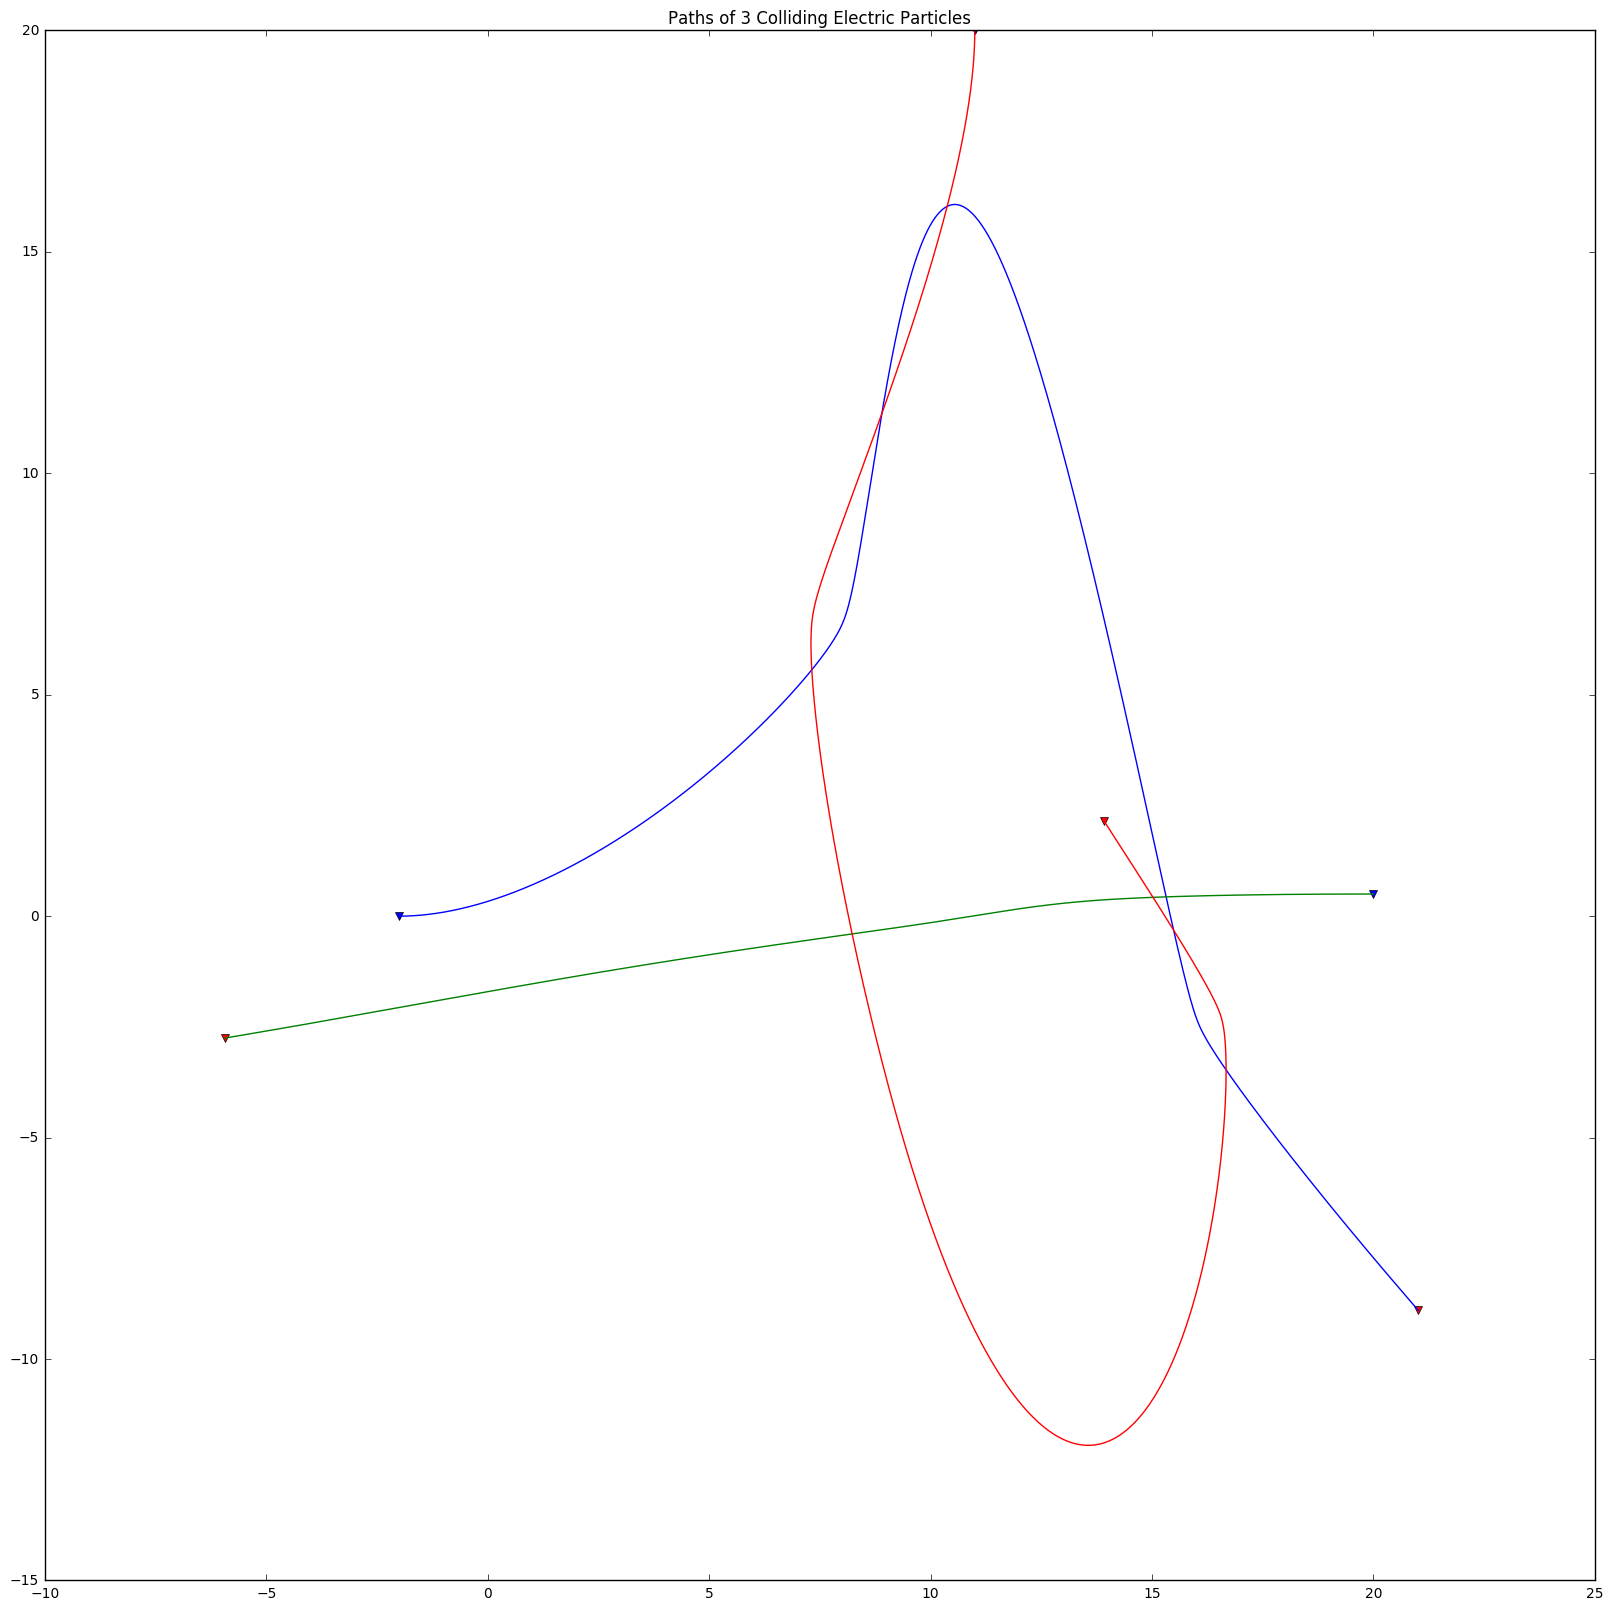

In [454]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

fig = plt.figure(figsize=(20,20))
#ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(111)
ys1 = yf[:,0,1]
xs1 = yf[:,0,0]


xs2 = yf[:,1,0]
ys2 = yf[:,1,1]

xs3 = yf[:,2,0]
ys3 = yf[:,2,1]

ax.plot(xs1[1], ys1[1],'bv')     
ax.plot(xs1[-1], ys1[-1], 'rv') 

ax.plot(xs2[:1], ys2[:1], 'bv')    
ax.plot(xs2[-1:], ys2[-1:], 'rv') 

ax.plot(xs3[:1], ys3[:1], 'bv')    
ax.plot(xs3[-1:], ys3[-1:], 'rv') 
# 
# minx = np.min(y[:,[0,2],0]) 
# maxx = np.max(y[:,[0,2],0]) 

# miny = np.min(y[:,[0,2],1]) 
# maxy = np.max(y[:,[0,2],1])
                                         
ax.plot(xs1, ys1)                      
ax.plot(xs2, ys2)    
ax.plot(xs3, ys3)                      


# plt.xlim(xmin=minx, xmax=maxx)
# plt.ylim(ymin=miny, ymax=maxy)

plt.title("Paths of 3 Colliding Electric Particles")
plt.ion()
plt.show()
